In [1]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import plotly.express as px
import plotly.io as pio
import seaborn as sns

from pathlib import Path
import pandas as pd
import numpy as np
import itertools
import glob

import statsmodels.api as sm
import scipy.stats as stats

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go

pio.renderers.default = "iframe"

In [2]:
def calculate_distribution_mean(slope: float,
                                x_min: float,
                                x_max: float):
    scaling = 1 / (1 - (x_min / x_max)**slope)
    return (scaling * slope / (1 - slope)) * (x_max*(x_min/x_max)**slope - x_min)


def fix_up_df(df: pd.DataFrame):
    df["z"] = df.z.fillna(0)
    df["za"] = df.za.fillna(0)
    df["x_min"] = 5
    df["x_max"] = 1000
    df["expected_mean_radius"] = calculate_distribution_mean(df.slope, df.x_min, df.x_max)
    df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)
    df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
    df["log_stdev_N"] = np.log10(np.sqrt(df.variance))

        
    return df[df.isna().sum(axis=1) == 0].reset_index(drop=True).copy()

In [9]:
def plot_log_stdev_N_and_ir_for_simulation(simulation_id: int, stats_df: pd.DataFrame):
    df = stats_df[stats_df.simulation_id == simulation_id]
    df.head()
    
    print(df[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0])
    
    fig = plt.figure(figsize=(12, 3))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.information_remaining, color='red', label="Information Remaining")
    ax1.set_ylabel("Information Remaining")
    ax1.set_xlabel("N Craters Added")
    
    ax2 = ax1.twinx()
    plt2 = ax2.plot(df.n_craters_added_in_study_region, df.log_stdev_N, color="blue", label="log(stdev N)")
    ax2.set_ylabel("log(stdev N)")
    
    lns = plt1 + plt2
    ax1.legend(lns, [l.get_label() for l in lns], loc=1)
    
    ax1.set_title(f"Simulation {simulation_id}")

    plt.show()

In [4]:
ivs = [
    "slope",
    "effective_radius_multiplier",
    "r_stat_multiplier",
    "min_rim_percentage",
    "expected_mean_radius",
    "z",
    "za",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "n_craters_in_study_region",
]

non_constant_ivs = [
    "z",
    "za",
    "expected_mean_radius",
    "areal_density",
    "areal_density_overlap_2",
    "areal_density_overlap_3",
    "center_to_center_nearest_neighbor_distance_mean",
    "center_to_center_nearest_neighbor_distance_stdev",
    "center_to_center_nearest_neighbor_distance_min",
    "center_to_center_nearest_neighbor_distance_max",
    "n_craters_in_study_region",
]

iv_labels = {
    "slope": "$b$",
    "effective_radius_multiplier": "$E_{mult}$",
    "r_stat_multiplier": "$E_{ratio}$",
    "min_rim_percentage": "$M_r$",
    "n_craters_in_study_region": "$N_S$",
    "areal_density": "Median $A_d$",
    "information_remaining": "Information Remaining",
}

In [5]:
# # base_path = "/data/saturation/random_runs_20230812/"
# # base_path = "/data/saturation/ir_random_1/"

# stats_df = pd.read_parquet(f"{base_path}/train_1000_100.parquet").sort_values("crater_id")
# # stats_df = pd.read_parquet(f"{base_path}/train_10.parquet").sort_values("crater_id")
# stats_df = fix_up_df(stats_df)

# test_df = pd.read_parquet(f"{base_path}/test_1000_100.parquet").sort_values("crater_id")
# # test_df = pd.read_parquet(f"{base_path}/test_10.parquet").sort_values("crater_id")
# test_df = fix_up_df(test_df)

# simulation_ids = stats_df.simulation_id.unique()

In [6]:
base_path = "/data/saturation/n_craters_stop_condition_20230918"

train_df = pd.read_parquet(f"{base_path}/train_with_variance.parquet")
train_df = fix_up_df(train_df)

test_df = pd.read_parquet(f"{base_path}/test_with_variance.parquet")
test_df = fix_up_df(test_df)

stats_df = pd.concat([train_df, test_df], axis=0)
simulation_ids = stats_df.simulation_id.unique()

metric = "log_stdev_N"

### Visualizing Log Stdev and IR for a few simulations

For some simulations, variance seems to start low and quickly reach a higher steady state, as expected. For others, it appears mostly constant.

This may be because only a handful (< 500) observations are sampled from each simulation. This should be repeated with a larger sampling.

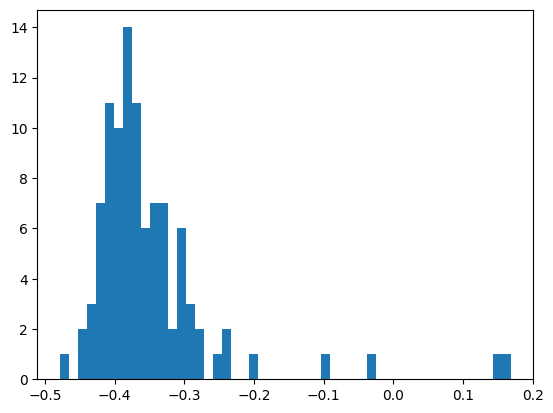

In [7]:
plt.hist(stats_df[stats_df.simulation_id == simulation_ids[8]].log_stdev_N, bins=50)
plt.show()

slope                          1.224862
effective_radius_multiplier    1.881520
r_stat_multiplier              7.882473
min_rim_percentage             0.293945
Name: 8, dtype: float64


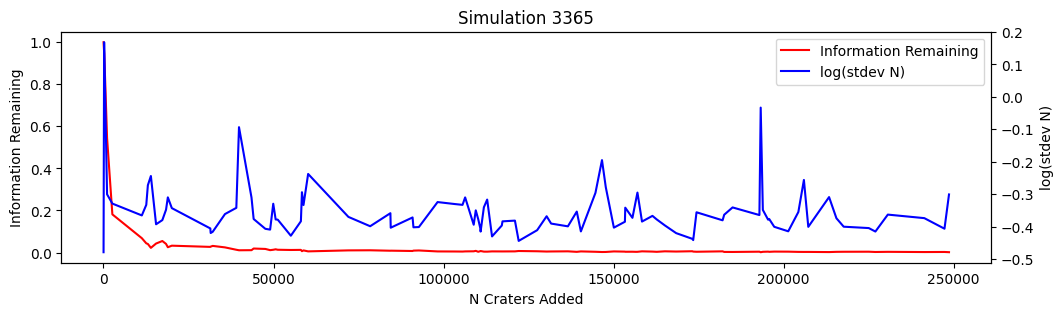

slope                          1.354802
effective_radius_multiplier    1.691609
r_stat_multiplier              3.820493
min_rim_percentage             0.272853
Name: 9, dtype: float64


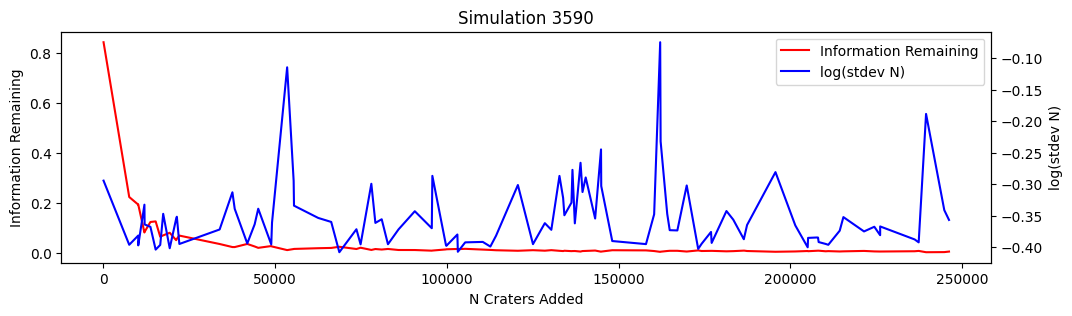

slope                          1.364501
effective_radius_multiplier    1.237981
r_stat_multiplier              3.035237
min_rim_percentage             0.537340
Name: 10, dtype: float64


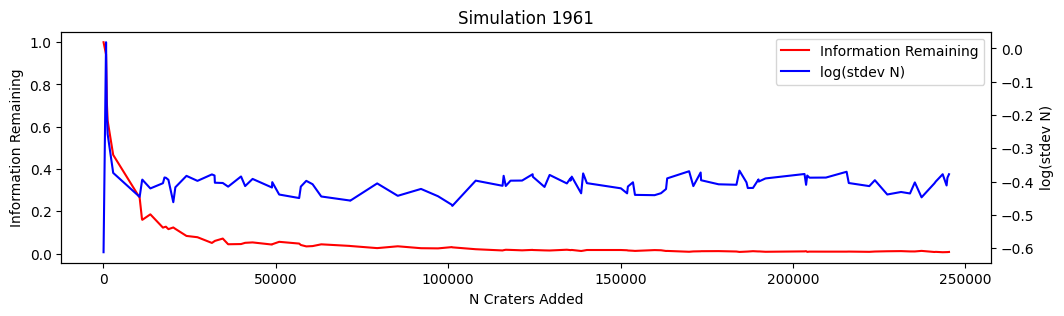

slope                          1.062741
effective_radius_multiplier    1.155596
r_stat_multiplier              4.995146
min_rim_percentage             0.425419
Name: 11, dtype: float64


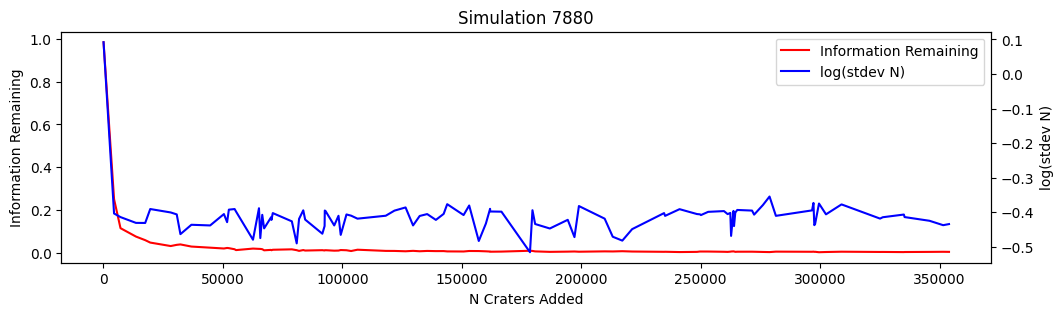

slope                          1.034058
effective_radius_multiplier    1.890641
r_stat_multiplier              3.091325
min_rim_percentage             0.477090
Name: 12, dtype: float64


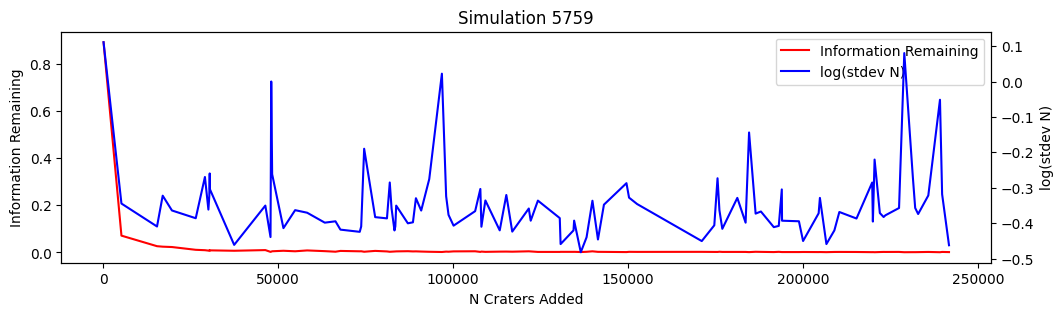

slope                          2.736538
effective_radius_multiplier    1.124631
r_stat_multiplier              3.279235
min_rim_percentage             0.286741
Name: 13, dtype: float64


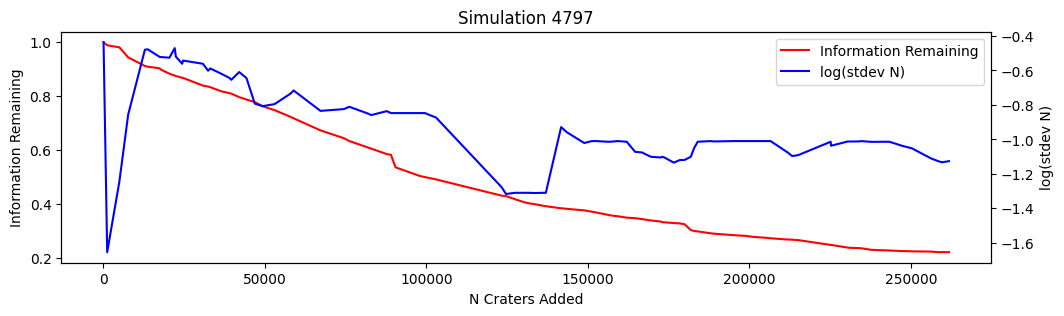

slope                          2.360365
effective_radius_multiplier    1.296415
r_stat_multiplier              3.249547
min_rim_percentage             0.425286
Name: 14, dtype: float64


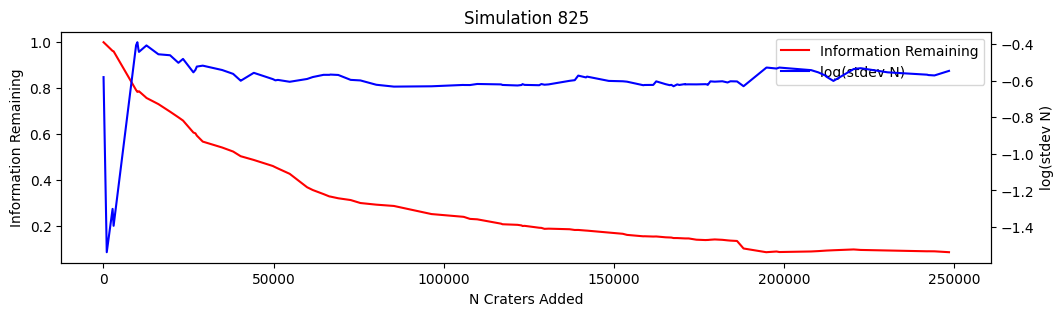

In [10]:
for x in range(8, 15):
    plot_log_stdev_N_and_ir_for_simulation(simulation_ids[x], stats_df)

### Examining Relationships

#### All correlations

In [ ]:
sns.heatmap(stats_df[ivs + ["log_stdev_N", "information_remaining", "n_craters_added_in_study_region"]].corr())

In [ ]:
sns.heatmap(np.log(stats_df[ivs + ["information_remaining", "n_craters_added_in_study_region"]]).corr())

In [ ]:
stats_df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

#### Plots of IVs vs Log Stdev N

The plot of log(N) by log(stdev N) has a very odd shape. I'm not sure how to interpret this.

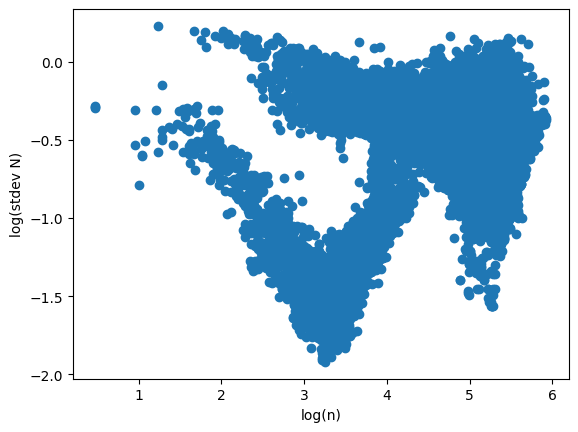

In [11]:
plt.scatter(stats_df.log_n_craters_added_in_study_region, stats_df.log_stdev_N)
plt.xlabel("log(n)")
plt.ylabel("log(stdev N)")
plt.show()

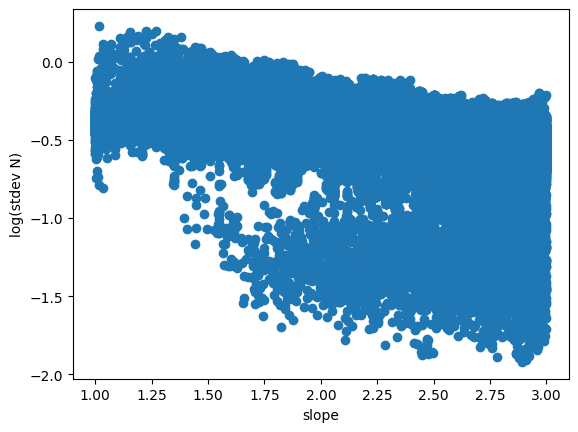

In [12]:
plt.scatter(stats_df.slope, stats_df.log_stdev_N)
plt.xlabel("slope")
plt.ylabel("log(stdev N)")
plt.show()

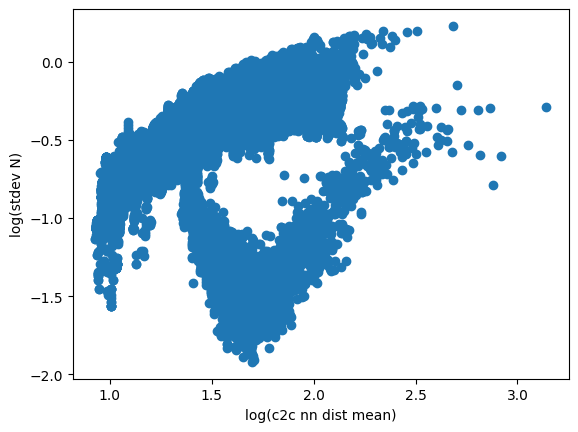

In [13]:
plt.scatter(stats_df.log_center_to_center_nearest_neighbor_distance_mean, stats_df.log_stdev_N)
plt.xlabel("log(c2c nn dist mean)")
plt.ylabel("log(stdev N)")
plt.show()

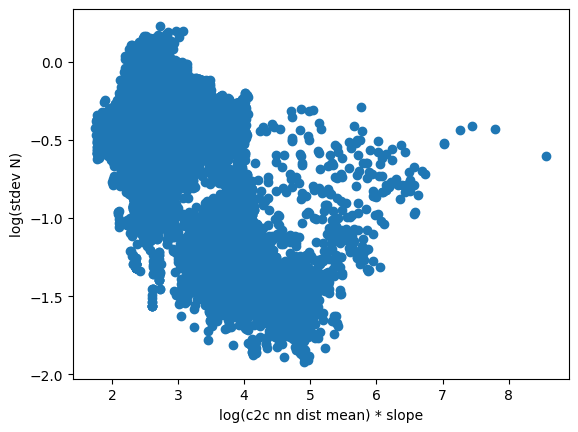

In [14]:
plt.scatter(stats_df.log_center_to_center_nearest_neighbor_distance_mean * stats_df.slope, stats_df.log_stdev_N)
plt.xlabel("log(c2c nn dist mean) * slope")
plt.ylabel("log(stdev N)")
plt.show()

In [ ]:
for x in non_constant_ivs:
    plt.scatter(stats_df[x], stats_df.log_stdev_N)
    plt.xlabel(f"{x}")
    plt.ylabel("log(stdev N)")
    plt.show()

In [ ]:
for x in non_constant_ivs:
    plt.scatter(np.log10(stats_df[x]), stats_df.log_stdev_N)
    plt.xlabel(f"log({x})")
    plt.ylabel("log(stdev N)")
    plt.show()

Examining correlation matrices of observations with high vs low IR.

- IR vs distance metrics correlations greatly diminishes when IR is low.
- Effective radius correlation increases in higher IR.
- Min rim percentage correlation increases in higher IR.

In [ ]:
df = stats_df[stats_df.information_remaining > 0.7].copy()
sns.heatmap(df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr())

In [ ]:
df = stats_df[stats_df.information_remaining < 0.5].copy()
sns.heatmap(df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr())

Correlation differences between high IR and low IR observations.

First heatmap: positive = higher correlation in high IR

Second heatmap: abs differences in correlations

Third heatmap: abs differences in correlations of log-transformed data

Notes:
- Slope has higher correlation with distance metrics in high IR
- z, za, and AD metrics have higher correlation with high IR
- Sim parameters (eff radius, r_stat, slope, min rim perc) appear to have the same correlation in high and low IR
- Log-transformed distance metrics have much higher correlation with high IR

In [ ]:
df = stats_df[stats_df.information_remaining > 0.7].copy()
corr1 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

df = stats_df[stats_df.information_remaining < 0.5].copy()
corr2 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

sns.heatmap(corr1 - corr2)

In [ ]:
df = stats_df[stats_df.information_remaining > 0.7].copy()
corr1 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

df = stats_df[stats_df.information_remaining < 0.5].copy()
corr2 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

sns.heatmap(np.abs(corr1 - corr2))

In [ ]:
df = np.log(stats_df[stats_df.information_remaining > 0.7].copy())
corr1 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

df = np.log(stats_df[stats_df.information_remaining < 0.5].copy())
corr2 = df[ivs + ["information_remaining", "n_craters_added_in_study_region"]].corr()

sns.heatmap(np.abs(corr1 - corr2))

#### Exploratory plots of distance metrics

mean center-to-center nearest neighbor distance showed a peculiar relationship in the previous sections. Let's examine further.

In [15]:
df = stats_df #[stats_df.information_remaining < 0.5].copy()
# df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)

df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_removals"] = np.log10(1 + df.removals)
df["log_areal_density"] = np.log10(df.areal_density)
df["color"] = df.min_rim_percentage * df.effective_radius_multiplier

fig = px.scatter(
    df,
    x="log_removals",
    y="log_areal_density",
    hover_data=ivs + ["removals", "information_remaining"],
    size_max=0.25,
    color="slope"
)
fig.show()

In [16]:
ir_lower = 0.4
delta = 0.01
# df = stats_df[(stats_df.information_remaining >= ir_lower) & (stats_df.information_remaining <= ir_lower + delta)].copy()
# df = stats_df[stats_df.simulation_id == 11].copy()
df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)
df["log_za"] = np.log10(df.za)

df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_removals"] = np.log10(1 + df.n_craters_added_in_study_region - df.n_craters_in_study_region)
df["removals"] = df.n_craters_added_in_study_region - df.n_craters_in_study_region
df["color"] = df.min_rim_percentage * df.effective_radius_multiplier
df["e_slope"] = np.exp(df.slope)

fig = px.scatter(
    df,
    y="log_n_craters_added_in_study_region",
    x="log_center_to_center_nearest_neighbor_distance_mean",
    hover_data=ivs + ["removals"],
    size_max=1,
    color="slope",
)
fig.show()

/home/mason/code/saturation/venv_311/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning:

invalid value encountered in log10



In [ ]:
base_path = "/data/saturation/random_runs_20230812/"
# base_path = "/data/saturation/ir_random_1/"
# base_path = "/data/saturation/n_craters_stop_condition_20230918"

# stats_df = pd.read_parquet(f"{base_path}/train_1000_100.parquet").sort_values("crater_id")
stats_df = pd.read_parquet(f"{base_path}/train_10.parquet").sort_values("crater_id")
stats_df = fix_up_df(stats_df)

# test_df = pd.read_parquet(f"{base_path}/test_1000_100.parquet").sort_values("crater_id")
test_df = pd.read_parquet(f"{base_path}/test_10.parquet").sort_values("crater_id")
test_df = fix_up_df(test_df)

simulation_ids = stats_df.simulation_id.unique()

In [ ]:
df = stats_df.copy()
df = df[df.n_craters_in_study_region > 25]
# df = df.sample(df.shape[0] // 10).copy()

min_slope = 2.0
max_slope = 2.1

df = df[(df.slope > min_slope) & (df.slope < max_slope)]
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)
df["log_n_craters_in_study_region"] = np.log10(df.n_craters_in_study_region)

fig = px.scatter(
    df,
    x="log_center_to_center_nearest_neighbor_distance_mean",
    y="log_n_craters_added_in_study_region",
    hover_data=ivs + ["information_remaining"],
    size_max=1,
    color="log_n_craters_in_study_region",
)
fig.show()

In [ ]:
from saturation.distributions import ProbabilityDistribution, ParetoProbabilityDistribution

slope = 2
x_min = 5
x_max = 1000

size_distribution = ParetoProbabilityDistribution(cdf_slope=slope,
                                                  x_min=x_min,
                                                  x_max=x_max)
size_distribution.pullback(np.random.rand(10000)).mean()

In [ ]:
# Trying to approximate variance
df = stats_df.copy()

slope_center = 2
slope_epsilon = .1
min_slope = slope_center - slope_epsilon
max_slope = slope_center + slope_epsilon
interior_min = slope_center - slope_epsilon / 2
interior_max = slope_center + slope_epsilon / 2

calc_df = df[(df.slope >= interior_min) & (df.slope < interior_max)].sort_values("center_to_center_nearest_neighbor_distance_mean").copy()
search_df = df[(df.slope >= min_slope) & (df.slope < max_slope)][["center_to_center_nearest_neighbor_distance_mean"]].sort_values("center_to_center_nearest_neighbor_distance_mean").reset_index(drop=True).copy()
search_df["idx"] = range(search_df.shape[0])

results = []
for row in calc_df.itertuples():
    print(row.Index)
    break

In [ ]:
search_df

In [ ]:
merged = pd.merge_asof(
    calc_df,
    search_df,
    left_on="center_to_center_nearest_neighbor_distance_mean",
    right_on="center_to_center_nearest_neighbor_distance_mean",
    allow_exact_matches=False,
    direction="nearest"
)

In [ ]:
search_df.reset_index()

In [ ]:
# Dione 1
d_min = 4000 # meters
r_min = d_min / 2
area = 102449 # km^2
n_craters = 65

area_m = area * 1000**2
area_r_min = area_m / r_min**2
intensity = n_craters / area_r_min
intensity

In [ ]:
# Dione 2
d_min = 4000 # meters
r_min = d_min / 2
area = 62647 # km^2
n_craters = 192

area_m = area * 1000**2
area_r_min = area_m / r_min**2
intensity = n_craters / area_r_min
intensity

In [ ]:
# Dione 3
d_min = 4000 # meters
r_min = d_min / 2
area = 53552 # km^2
n_craters = 265

area_m = area * 1000**2
area_r_min = area_m / r_min**2
intensity = n_craters / area_r_min
intensity

In [ ]:
# Dione 4
d_min = 4000 # meters
r_min = d_min / 2
area = 38712 # km^2
n_craters = 265

area_m = area * 1000**2
area_r_min = area_m / r_min**2
intensity = n_craters / area_r_min
intensity

In [ ]:
# Sim terrain
r_min = 5 # units
area = 4000**2 # unit^2
n_craters = 3500

area_r_min = area / r_min**2
intensity = n_craters / area_r_min
intensity

In [ ]:
"""
slope 1.1 -> 22.27, c2c_mean ~= 105
slope 1.5 -> 13.78, c2c_mean ~= 50
slope 2   -> 9.81,  c2c_mean ~= 31
slope 2.2 -> 9.15,  c2c_mean ~= 29.6
slope 2.5 -> 8.26,  c2c_mean ~= 26
slope 2.9 -> 7.635, c2c_mean ~= 24
"""

In [ ]:
plt.scatter([22.27, 13.78, 9.81, 9.15, 8.26, 7.635], [105, 50, 31, 29.6, 26, 24])

In [ ]:
stats.linregress([22.27, 13.78, 9.81, 8.26, 7.635], [105, 50, 31, 26, 24])

### Modeling variance

Goal: model the variance (with a CI) of N given c2c_mean, slope
- Linear regression first
- Response: log sqrt (variance of N)
    - Possibly bucketed to calculate variance



In [ ]:
df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)

fig = px.scatter_3d(
    df,
    x="slope",
    y="log_center_to_center_nearest_neighbor_distance_mean",
    z="log_n_craters_added_in_study_region",
    hover_data=ivs + ["removals"],
    size_max=1,
    color="effective_radius_multiplier",
    width=1600,
    height=800
)
fig.update_traces(marker={"size":3})
fig.show()

In [ ]:
# base_path = "/data/saturation/random_runs_20230812/"
# base_path = "/data/saturation/ir_random_1/"
base_path = "/data/saturation/n_craters_stop_condition_20230918"

stats_df = pd.read_parquet(f"{base_path}/train_1000_100.parquet").sort_values("crater_id")
# stats_df = pd.read_parquet(f"{base_path}/train_10.parquet").sort_values("crater_id")
stats_df = fix_up_df(stats_df)

test_df = pd.read_parquet(f"{base_path}/test_1000_100.parquet").sort_values("crater_id")
# test_df = pd.read_parquet(f"{base_path}/test_10.parquet").sort_values("crater_id")
test_df = fix_up_df(test_df)

simulation_ids = stats_df.simulation_id.unique()

In [ ]:
df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()

min_slope = 2
max_slope = 3

df = df[(df.slope > min_slope) & (df.slope < max_slope)]
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)

fig = px.scatter(
    df,
    x="log_center_to_center_nearest_neighbor_distance_mean",
    y="log_n_craters_added_in_study_region",
    hover_data=ivs + ["information_remaining"],
    size_max=1,
    color="slope",
)
fig.show()

In [ ]:
df = stats_df.copy()
df = df.sample(df.shape[0] // 10).copy()
df["log_center_to_center_nearest_neighbor_distance_mean"] = np.log10(df.center_to_center_nearest_neighbor_distance_mean)
df["log_n_craters_added_in_study_region"] = np.log10(df.n_craters_added_in_study_region)

fig = px.scatter_3d(
    df,
    x="slope",
    y="log_center_to_center_nearest_neighbor_distance_mean",
    z="log_n_craters_added_in_study_region",
    hover_data=ivs + ["removals"],
    size_max=1,
    color="effective_radius_multiplier",
    width=1600,
    height=800
)
fig.update_traces(marker={"size":3})
fig.show()

In [ ]:
# base_path = "/data/saturation/random_runs_20230812/"
# base_path = "/data/saturation/ir_random_1/"
base_path = "/data/saturation/n_craters_stop_condition_20230918"

stats_df = pd.read_parquet(f"{base_path}/train_1000_500.parquet").sort_values("crater_id")
# stats_df = pd.read_parquet(f"{base_path}/train_10.parquet").sort_values("crater_id")
stats_df = fix_up_df(stats_df)

test_df = pd.read_parquet(f"{base_path}/test_1000_500.parquet").sort_values("crater_id")
# test_df = pd.read_parquet(f"{base_path}/test_10.parquet").sort_values("crater_id")
test_df = fix_up_df(test_df)

simulation_ids = stats_df.simulation_id.unique()

In [ ]:
def plot_n_vs_N_for_simulation(simulation_id: int, stats_df: pd.DataFrame):
    df = stats_df[stats_df.simulation_id == simulation_id]
    
    print(df[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0])
    
    fig = plt.figure(figsize=(18, 4))
    ax1 = fig.add_subplot(111)
    
    plt1 = ax1.plot(df.n_craters_added_in_study_region, df.n_craters_in_study_region, color='red')
    ax1.set_ylabel("n")
    ax1.set_xlabel("N")
    
    ax1.set_title(f"Simulation {simulation_id}")
    plt.show()


def plot_n_hist_for_simulation(simulation_id: int, stats_df: pd.DataFrame):
    df = stats_df[stats_df.simulation_id == simulation_id]
    min_N = int(df.n_craters_added_in_study_region.max() * 2 / 3)
    df = df[df.n_craters_added_in_study_region > min_N]
   
    print(df[["slope", "effective_radius_multiplier", "r_stat_multiplier", "min_rim_percentage"]].iloc[0])
    
    plt.hist(df.n_craters_in_study_region, bins=25)
    plt.show()

In [ ]:
for x in range(29, 30):
    plot_n_vs_N_for_simulation(simulation_ids[x], stats_df)

In [ ]:
for x in range(29, 30):
    plot_n_hist_for_simulation(simulation_ids[x], stats_df)

In [ ]:
sim_dir = "1.523_0.536_3.984_2.079"

df = None
for filename in glob.glob(f"/data/saturation/n_craters_stop_condition_20230918/{sim_dir}/statistics*.parquet"):
    if df is None:
        df = pd.read_parquet(filename)
    else:
        df = pd.concat([df, pd.read_parquet(filename)], axis=0)

min_N = int(df.n_craters_added_in_study_region.max() * 2 / 3)
# plt.hist(df[df.n_craters_added_in_study_region > min_N].n_craters_in_study_region, bins=25)
plt.hist(df[df.n_craters_added_in_study_region > 40000].n_craters_in_study_region, bins=25)
plt.show()

In [ ]:
df[df.n_craters_added_in_study_region > min_N].n_craters_in_study_region.quantile(0.01)

In [ ]:
df[df.n_craters_added_in_study_region > 40000].n_craters_in_study_region.quantile(0.01)